In [57]:
import pandas as pd
import csv

# Load the CSV file
data = pd.read_csv("sound_recordings.csv")

# Display the first few rows to verify the data
print(data.head())


   Time (ms)  Sound Level
0   0.000352          489
1   0.001062          489
2   0.001472          489
3   0.001857          489
4   0.002256          489


In [58]:
print("Descriptive Statistics:")
print(data['Sound Level'].describe())


Descriptive Statistics:
count    1923.000000
mean      492.584503
std        33.908482
min       204.000000
25%       492.000000
50%       493.000000
75%       494.000000
max       832.000000
Name: Sound Level, dtype: float64


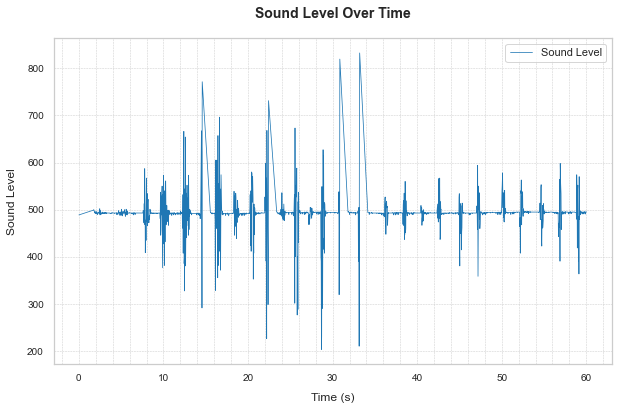

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Use Seaborn's 'darkgrid' style
sns.set(style='whitegrid')

# Plot sound level over time
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot with a smoother line, markers, and better color options
plt.plot(data['Time (ms)'], np.abs(data['Sound Level']), color='tab:blue', linewidth=0.75, label='Sound Level')

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the labels and title
plt.xlabel('Time (s)', fontsize=12, labelpad=10)
plt.ylabel('Sound Level', fontsize=12, labelpad=10)
plt.title('Sound Level Over Time', fontsize=14, fontweight='bold', pad=20)

# Add a legend
plt.legend(loc='upper right')

# Customize the tick marks for better visibility
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


### find peaks in the Sound Level vs. time plot


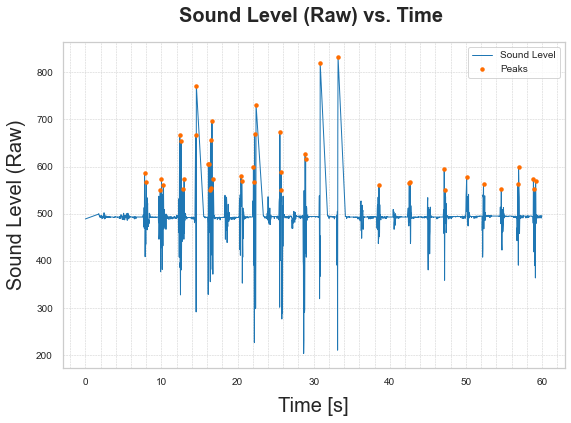

In [60]:

from scipy.signal import find_peaks

# Detect peaks in sound level data
peaks, _ = find_peaks(data['Sound Level'], height=550)  # Adjust 'height' for sensitivity

# Use Seaborn's 'darkgrid' style
sns.set(style='whitegrid')
# Plot sound level with peaks marked
plt.figure(figsize=(9, 6))  # Larger figure size for better clarity

# Plot sound level with a smooth line
plt.plot(data['Time (ms)'], data['Sound Level'], label="Sound Level", color='tab:blue', linewidth=1)

# Mark the detected peaks with red 'x' markers
plt.plot(data['Time (ms)'][peaks], data['Sound Level'][peaks], 'o', label="Peaks", color='#FF6D00', markersize=2.5, markeredgewidth=2)

# Customize the plot
plt.xlabel('Time [s]', fontsize=20, labelpad=10)
plt.ylabel('Sound Level (Raw)', fontsize=20, labelpad=10)
plt.title('Sound Level (Raw) vs. Time ', fontsize=20, fontweight='bold', pad=20)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend to describe the data series
plt.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1, 1))

# Customize the tick marks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set background color of the plot area for better contrast
#plt.gca().set_facecolor('whitesmoke')

plt.savefig("SoundRaw_time.svg")   # Save as SVG
#plt.savefig("SoundRaw_time.png")   # Save as PNG

# Display the plot
plt.show()


### print the noise level

In [61]:
noise_level = data['Sound Level'].median()
print(f"Estimated noise level: {noise_level}")

Estimated noise level: 493.0


### CONVERT Raw Sound Levels into Voltage

In [62]:
# Function to convert raw data to volts
def raw_to_volts(raw_value, reference_voltage=5.0, max_adc_value=1023):
    """
    Convert raw ADC data to volts.
    
    Parameters:
    raw_value (int): The raw analog reading from the Arduino (0 to 1023).
    reference_voltage (float): The reference voltage of the Arduino (default 5.0V).
    max_adc_value (int): The maximum ADC value (default 1023 for 10-bit resolution).
    
    Returns:
    float: The voltage corresponding to the raw ADC value.
    """
    return (raw_value / max_adc_value) * reference_voltage


In [63]:
for raw_value in data['Sound Level']:
        voltage = raw_to_volts( data['Sound Level'], 5)

## Plot sound levels [Volts]

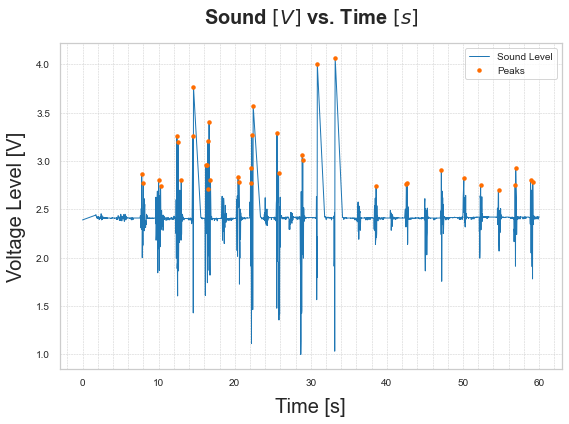

In [64]:
# Detect peaks in sound level data
peaks, _ = find_peaks(voltage, height=2.7)  # Adjust 'height' for sensitivity

# Use Seaborn's 'darkgrid' style
sns.set(style='whitegrid')
# Plot sound level with peaks marked
plt.figure(figsize=(9, 6))  # Larger figure size for better clarity

# Plot sound level with a smooth line
plt.plot(data['Time (ms)'], voltage, label="Sound Level", color='tab:blue', linewidth=1)

# Mark the detected peaks with red 'x' markers
plt.plot(data['Time (ms)'][peaks], voltage[peaks], 'o', label="Peaks", color='#FF6D00', markersize=2.5, markeredgewidth=2)

# Customize the plot
plt.xlabel('Time [s]', fontsize=20, labelpad=10)
plt.ylabel('Voltage Level [V]', fontsize=20, labelpad=10)
plt.title('Sound $[V]$ vs. Time $[s]$', fontsize=20, fontweight='bold', pad=20)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend to describe the data series
plt.legend(loc='upper right', fontsize=10)

# Customize the tick marks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set background color of the plot area for better contrast
#plt.gca().set_facecolor('whitesmoke')

plt.savefig("SoundVolt_time.svg")   # Save as SVG
#plt.savefig("SoundVolt_time.png")   # Save as PNG

# Display the plot
plt.show()


In [65]:
 find_peaks(voltage, height=3.5)


(array([ 460,  698,  962, 1012]),
 {'peak_heights': array([3.76832845, 3.57282502, 4.00293255, 4.06647116])})

# FFT

## perform fft 

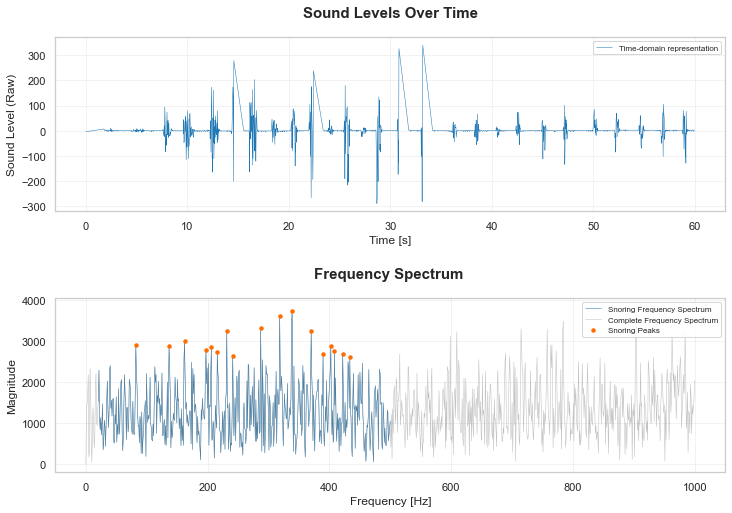

In [16]:

# Configuration
csv_filename = "sound_recordings.csv"  # Replace with your actual CSV file
sampling_rate = 2000  # Hz (based on Arduino delay)

# Load data from CSV
time = []
raw_data = []

with open(csv_filename, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    for row in reader:
        time.append(float(row[0]))       # Time column
        raw_data.append(float(row[1]))  # Sound level column
        
# Convert to numpy array
raw_data = np.array(raw_data)

# Remove DC offset
raw_data = raw_data - np.mean(raw_data)

# Zero-padding to the next power of 2
n = len(raw_data)
n_padded = 2**np.ceil(np.log2(n)).astype(int)
raw_data_padded = np.pad(raw_data, (0, n_padded - n), mode='constant')

# Perform FFT
fft_magnitudes = np.abs(np.fft.rfft(raw_data_padded))
frequencies = np.fft.rfftfreq(n_padded, d=1/sampling_rate)

# Real FFT gives symmetric spectrum

# Define the desired frequency range (for example, 50 Hz to 500 Hz)
min_freq = 20  # Minimum frequency in Hz
max_freq = 500  # Maximum frequency in Hz

# Filter out the frequencies that are outside the desired range
freq_range = (frequencies >= min_freq) & (frequencies <= max_freq)
filtered_frequencies =frequencies[freq_range]
filtered_magnitudes = fft_magnitudes[freq_range]

# Detect peaks in the filtered magnitude spectrum
peaks, _ = find_peaks(filtered_magnitudes, height=2600)  # Adjust 'height' for sensitivity


# Set Seaborn style
sns.set(style='whitegrid')

# Create the figure and subplots
plt.figure(figsize=(12, 8))  # Larger figure size

# Time-domain plot (Top subplot)
plt.subplot(2, 1, 1)
plt.plot(time, raw_data, color='tab:blue', linewidth=0.5, label='Time-domain representation')
plt.title("Sound Levels Over Time", fontsize=15, fontweight='bold', pad=20)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Sound Level (Raw)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Adding gridlines
plt.legend(loc='upper right', fontsize=8)

# Frequency-domain plot (Bottom subplot)
plt.subplot(2, 1, 2)
plt.plot(filtered_frequencies, filtered_magnitudes, color='tab:blue', linewidth=0.5, alpha= 1, label='Snoring Frequency Spectrum')
plt.plot(frequencies, fft_magnitudes, color='tab:grey', linewidth=0.5, alpha= 0.5, label='Complete Frequency Spectrum')
# Mark the detected peaks with orange 'o' markers
plt.plot(filtered_frequencies[peaks], filtered_magnitudes[peaks], 'o', label="Snoring Peaks", color='#FF6D00', markersize=2.5, markeredgewidth=2)


# Customize the plot
plt.title("Frequency Spectrum ", fontsize=15, fontweight='bold', pad=20)
plt.xlabel("Frequency [Hz]", fontsize=12)
plt.ylabel("Magnitude", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Adding gridlines
plt.legend(loc='upper right', fontsize=8)

# Adjust the vertical spacing
plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing

plt.savefig("FFT.svg")   # Save as SVG
plt.savefig("FFT.png")   # Save as PNG

# Show the plot
plt.show()


## Frequency spectrum

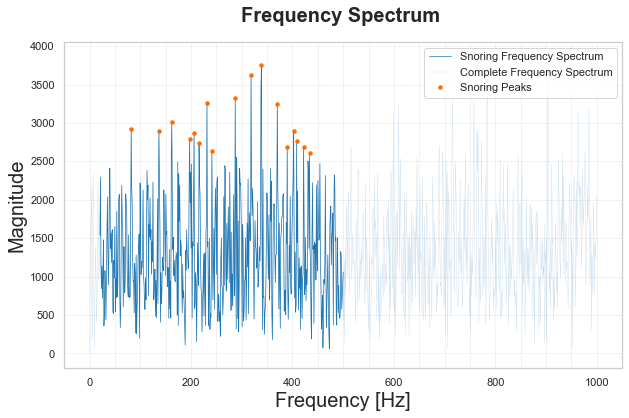

In [71]:
# Define the desired frequency range (for example, 50 Hz to 500 Hz)
min_freq = 20  # Minimum frequency in Hz
max_freq = 500  # Maximum frequency in Hz

# Filter out the frequencies that are outside the desired range
freq_range = (frequencies >= min_freq) & (frequencies <= max_freq)
filtered_frequencies =frequencies[freq_range]
filtered_magnitudes = fft_magnitudes[freq_range]

# Detect peaks in the filtered magnitude spectrum
peaks, _ = find_peaks(filtered_magnitudes, height=2600)  # Adjust 'height' for sensitivity



plt.figure(figsize=(10, 6))

# Set Seaborn style
sns.set(style='whitegrid')
plt.plot(filtered_frequencies, filtered_magnitudes, color='tab:blue', linewidth=0.7, label='Snoring Frequency Spectrum')
plt.plot(frequencies, fft_magnitudes, color='tab:blue', linewidth=0.3, alpha= 0.3, label='Complete Frequency Spectrum')
# Mark the detected peaks with orange 'o' markers
plt.plot(filtered_frequencies[peaks], filtered_magnitudes[peaks], 'o', label="Snoring Peaks", color='#FF6D00', markersize=2.5, markeredgewidth=2)


# Customize the plot
plt.title("Frequency Spectrum ", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Frequency [Hz]", fontsize=20)
plt.ylabel("Magnitude", fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Adding gridlines
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.savefig("FrequencySpectrum.svg")   # Save as SVG
plt.savefig("FrequencySpectrum.png")   # Save as PNG

### remove baseline


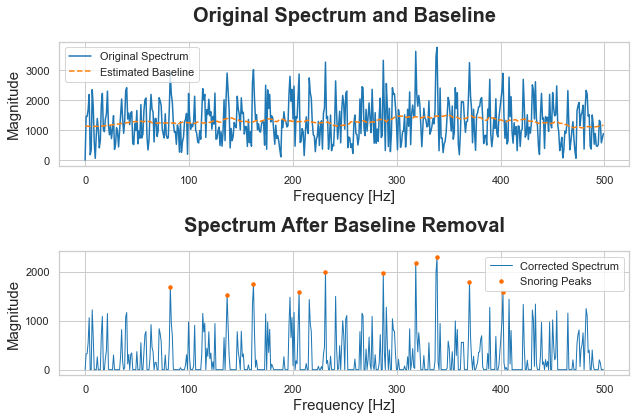

In [73]:
from scipy.signal import savgol_filter
# Perform FFT
fft_magnitudes = np.abs(np.fft.rfft(raw_data_padded))
frequencies = np.fft.rfftfreq(n_padded, d=1/sampling_rate)
magnitude = np.abs(fft_magnitudes)

# Apply Savitzky-Golay filter to estimate baseline
baseline = savgol_filter(magnitude, window_length=101, polyorder=3)

# Subtract the baseline from the magnitude spectrum
magnitude_corrected = magnitude - baseline

# Ensure no negative values (set them to zero)
magnitude_corrected[magnitude_corrected < 0] = 0

# Define the desired frequency range (for example, 50 Hz to 500 Hz)
min_freq = 20  # Minimum frequency in Hz
max_freq = 500  # Maximum frequency in Hz

# Filter out the frequencies that are outside the desired range
freq_range = (frequencies >= min_freq) & (frequencies <= max_freq)
filtered_frequencies =frequencies[freq_range]
filtered_magnitudes = magnitude_corrected[freq_range]

# Detect peaks in the filtered magnitude spectrum
peaks, _ = find_peaks(filtered_magnitudes, height=1500)  # Adjust 'height' for sensitivity




# Plot results
# Set Seaborn style
sns.set(style='whitegrid')

# Create the figure and subplots
plt.figure(figsize=(9, 6))  # Larger figure size

plt.subplot(2, 1, 1)
plt.plot(frequencies[:len(frequencies)//2], magnitude[:len(frequencies)//2], label='Original Spectrum', color='tab:blue')
plt.plot(frequencies[:len(frequencies)//2], baseline[:len(frequencies)//2], label='Estimated Baseline', linestyle='--', color='tab:orange')


plt.legend()
plt.title("Original Spectrum and Baseline", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Frequency [Hz]", fontsize=15)
plt.ylabel("Magnitude", fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], magnitude_corrected[:len(frequencies)//2], color='tab:blue', linewidth=1, label='Corrected Spectrum')
# Mark the detected peaks with orange 'o' markers
plt.plot(filtered_frequencies[peaks], filtered_magnitudes[peaks], 'o', label="Snoring Peaks", color='#FF6D00', markersize=2.5, markeredgewidth=2)



plt.legend()
plt.title("Spectrum After Baseline Removal", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Frequency [Hz]", fontsize=15)
plt.ylabel("Magnitude", fontsize=15)

plt.tight_layout()
plt.savefig("FrequencySpectrumBaseline.svg")   # Save as SVG
plt.show()


In [35]:
filtered_frequencies[peaks]


array([ 82.03125  , 136.71875  , 162.109375 , 206.0546875, 231.4453125,
       287.109375 , 318.359375 , 338.8671875, 370.1171875, 402.34375  ])

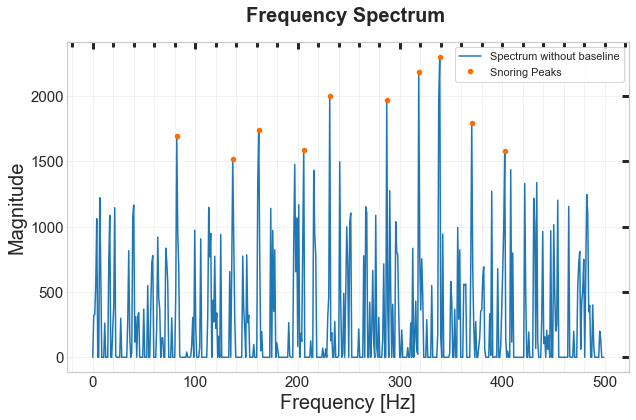

In [36]:
# Plot results
# Set Seaborn style
#sns.set(style='whitegrid')

# Create the figure 
plt.figure(figsize=(9, 6))  # Larger figure size
plt.plot(frequencies[:len(frequencies)//2], magnitude_corrected[:len(frequencies)//2], color='tab:blue', linewidth=1.5, label='Spectrum without baseline')
# Mark the detected peaks with orange 'o' markers
plt.plot(filtered_frequencies[peaks], filtered_magnitudes[peaks], 'o', label="Snoring Peaks", color='#FF6D00', markersize=3.5, markeredgewidth=2)

# Customize the plot
plt.title("Frequency Spectrum ", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Frequency [Hz]", fontsize=20)
plt.ylabel("Magnitude", fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Adding gridlines
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Set font size for x-axis and y-axis labels
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

# Adjust tick directions
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Show ticks on both top and right
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'

# Set major and minor tick widths
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['ytick.minor.width'] = 3

# Set major and minor tick sizes
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

# Ensure minor ticks are visible
plt.rcParams['xtick.minor.visible'] = 'True'

# Set font type for PDF and PS to Type 42 (TrueType)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42




plt.savefig("FrequencySpectrum_noBaseline.svg")   # Save as SVG
#plt.savefig("FrequencySpectrum_noBaseline.png")   # Save as PNG

plt.tight_layout()
plt.show()

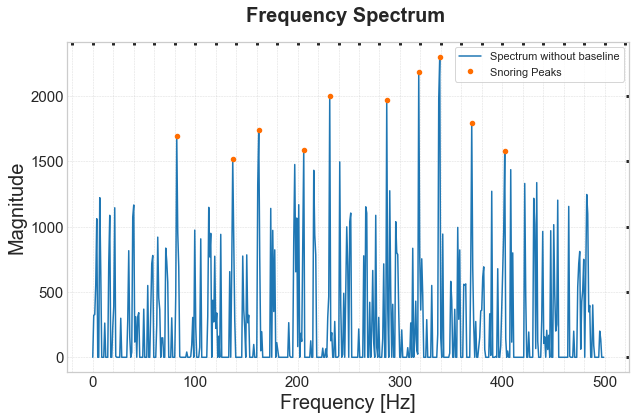

In [37]:
# Create the figure 
plt.figure(figsize=(9, 6))  # Larger figure size
plt.plot(frequencies[:len(frequencies)//2], magnitude_corrected[:len(frequencies)//2], color='tab:blue', linewidth=1.5, label='Spectrum without baseline')
# Mark the detected peaks with orange 'o' markers
plt.plot(filtered_frequencies[peaks], filtered_magnitudes[peaks], 'o', label="Snoring Peaks", color='#FF6D00', markersize=3.5, markeredgewidth=2)

# Customize the plot
plt.title("Frequency Spectrum ", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Frequency [Hz]", fontsize=20)
plt.ylabel("Magnitude", fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Adding gridlines
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))



# Set font type for PDF and PS to Type 42 (TrueType)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42




plt.savefig("FrequencySpectrum_noBaseline.svg")   # Save as SVG
#plt.savefig("FrequencySpectrum_noBaseline.png")   # Save as PNG

plt.tight_layout()
plt.show()